## Credit Card Fraud Detection Using Autoencode

### Declare required dependencies

In [1]:
import pandas as pd
import numpy as np
import pickle

from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from sklearn.metrics import (confusion_matrix, precision_recall_curve, auc,
                             roc_curve, recall_score, classification_report, f1_score,
                             precision_recall_fscore_support)

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

### Data ingestion

In [2]:
df = pd.read_csv('D:/creditcard.csv')

### Data exploration

In [3]:
df.head(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
print(df.shape)
print(df.describe())

(284807, 31)
                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  3.919560e-15  5.688174e-16 -8.769071e-15  2.782312e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.552563e-15  2.010663e-15 -1.694249e-15 -1.927028e-16 -3.137024e-15   
std    1.380247e+00  1.332271

### Is there any data missing ?

In [5]:
df.isnull().values.any()

False

### Class distribution ( 0 - non fraudulent, 1 - fraudulent)

In [6]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

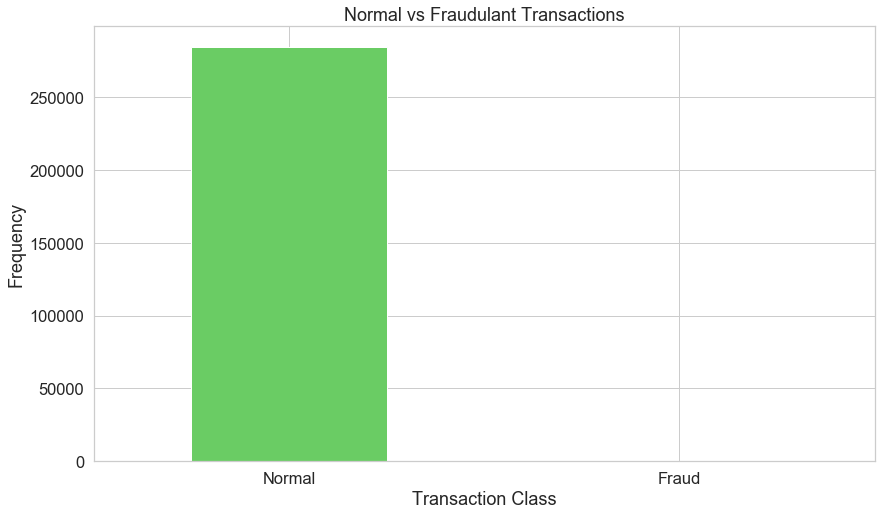

In [7]:
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0, color="g")
plt.title("Normal vs Fraudulant Transactions")
plt.xticks(range(2), LABELS)
plt.xlabel("Transaction Class")
plt.ylabel("Frequency");

Our dataset is very highly imbalanced in favour of negative(0, i.e normal) class. This requires further data exploration



In [9]:
fraudsDF = df[df.Class == 1]
normalDF = df[df.Class == 0]

In [10]:
fraudsDF.shape

(492, 31)

In [11]:
normalDF.shape

(284315, 31)

Let's now look at the amount of money involved across two classes

In [12]:
fraudsDF.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [14]:
normalDF.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

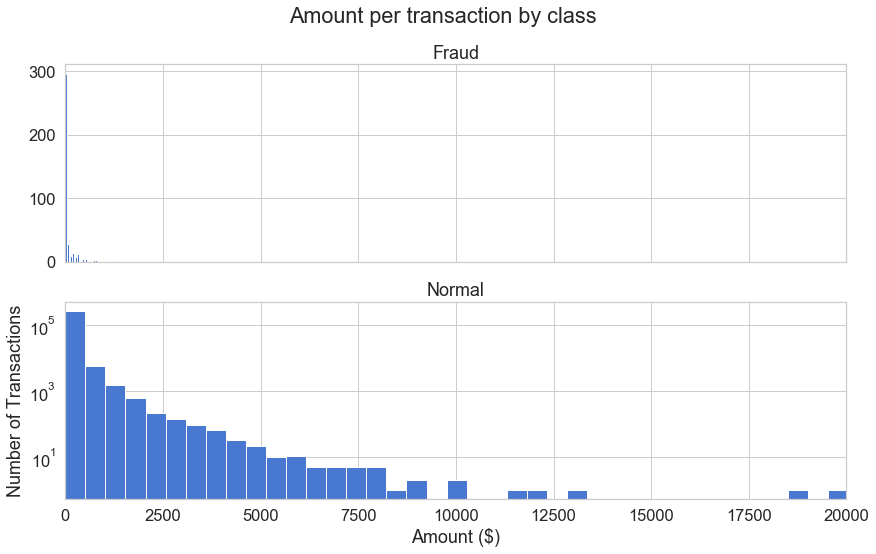

In [15]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by class')

bins = 50

ax1.hist(fraudsDF.Amount, bins = bins)
ax1.set_title('Fraud')

ax2.hist(normalDF.Amount, bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

Does time of transaction have any bearing on fraudulent activity

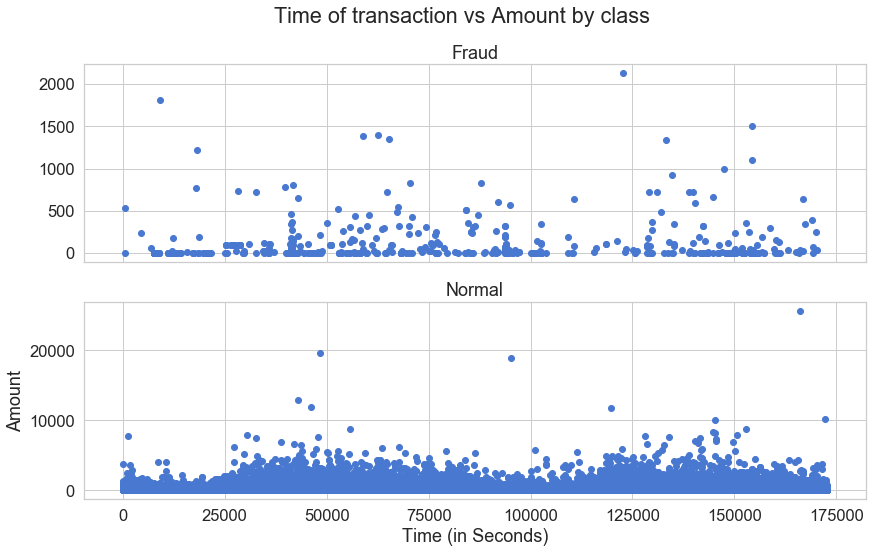

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Time of transaction vs Amount by class')

ax1.scatter(fraudsDF.Time, fraudsDF.Amount)
ax1.set_title('Fraud')

ax2.scatter(normalDF.Time, normalDF.Amount)
ax2.set_title('Normal')

plt.xlabel('Time (in Seconds)')
plt.ylabel('Amount')
plt.show()

So, it is clear that time of transaction has no bearing on the fraudulent activity.

### Preprocessing

Since, as shown above, time of transaction has no bearing on fraudulent activity, this feature is not going to contribute to model learning. Hence we can drop it.

In [18]:
transactionData = df.drop(['Time'], axis=1)

Also let us standardize the feature Amount.

In [19]:
transactionData['Amount'] = StandardScaler().fit_transform(transactionData['Amount'].values.reshape(-1, 1))

### Split the dataset in training and test datasets
We split the dataset as Training=80% and Test=20%. Training dataset will have only normal transactions and test dataset will have both normal and fraudulent transactions.

In [33]:
X_train, X_test = train_test_split(transactionData, test_size=0.2, random_state=RANDOM_SEED) 
#X_train : 227845 rows × 30 columns
X_train = X_train[X_train.Class == 0] # 227451 rows × 30 columns
X_train = X_train.drop(['Class'], axis=1)
#print(type(X_train))
y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)

X_train = X_train.values
#print(type(X_train))
X_test = X_test.values
y_test = y_test.values
print(y_test.size)
# Note : no Y_train here !

56962


### Model
We will build the autoencoder consisting of 4 fully connected layers with 14,7,7,29 neurons. First 2 layers act as encoder and last 2 layers act as decoder. Note last layer has 29 nodes corresponding to 29 feature in the input data item.

In [34]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(29, 14),
            nn.Tanh(),
            nn.Linear(14, 7),
            nn.LeakyReLU(),
            )
        
        self.decoder = nn.Sequential(
           nn.Linear(7, 7),
           nn.Tanh(),
           nn.Linear(7, 29),
           nn.LeakyReLU()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [76]:
model = Autoencoder().double()

In [77]:
num_epochs = 100
minibatch_size = 32
learning_rate = 1e-3

In [78]:
train_loader = data_utils.DataLoader(X_train, batch_size=minibatch_size, shuffle=True)
test_loader = data_utils.DataLoader(X_test, batch_size=1, shuffle=False)

In [79]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr=learning_rate, weight_decay=10e-05)

In [80]:
history = {}
history['train_loss'] = []
history['test_loss'] = []

In [81]:
for epoch in range(num_epochs):
    h = np.array([])
    for data in train_loader:
        #print(type(data))
        #data = Variable(data).cpu()
        #print(type(data))
        # ===================forward=====================
        output = model(data)
        loss = criterion(output, data)
        h = np.append(h, loss.item())
        
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    mean_loss = np.mean(h)
    print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, num_epochs, mean_loss))
    history['train_loss'].append(mean_loss)

epoch [1/100], loss:0.8000
epoch [2/100], loss:0.7373
epoch [3/100], loss:0.7268
epoch [4/100], loss:0.7230
epoch [5/100], loss:0.7205
epoch [6/100], loss:0.7176
epoch [7/100], loss:0.7127
epoch [8/100], loss:0.7088
epoch [9/100], loss:0.7063
epoch [10/100], loss:0.7051
epoch [11/100], loss:0.7046
epoch [12/100], loss:0.7041
epoch [13/100], loss:0.7037
epoch [14/100], loss:0.7037
epoch [15/100], loss:0.7036
epoch [16/100], loss:0.7036
epoch [17/100], loss:0.7034
epoch [18/100], loss:0.7034
epoch [19/100], loss:0.7033
epoch [20/100], loss:0.7030
epoch [21/100], loss:0.7031
epoch [22/100], loss:0.7033
epoch [23/100], loss:0.7030
epoch [24/100], loss:0.7028
epoch [25/100], loss:0.7029
epoch [26/100], loss:0.7030
epoch [27/100], loss:0.7027
epoch [28/100], loss:0.7028
epoch [29/100], loss:0.7027
epoch [30/100], loss:0.7027
epoch [31/100], loss:0.7024
epoch [32/100], loss:0.7022
epoch [33/100], loss:0.7018
epoch [34/100], loss:0.7018
epoch [35/100], loss:0.7017
epoch [36/100], loss:0.7018
e

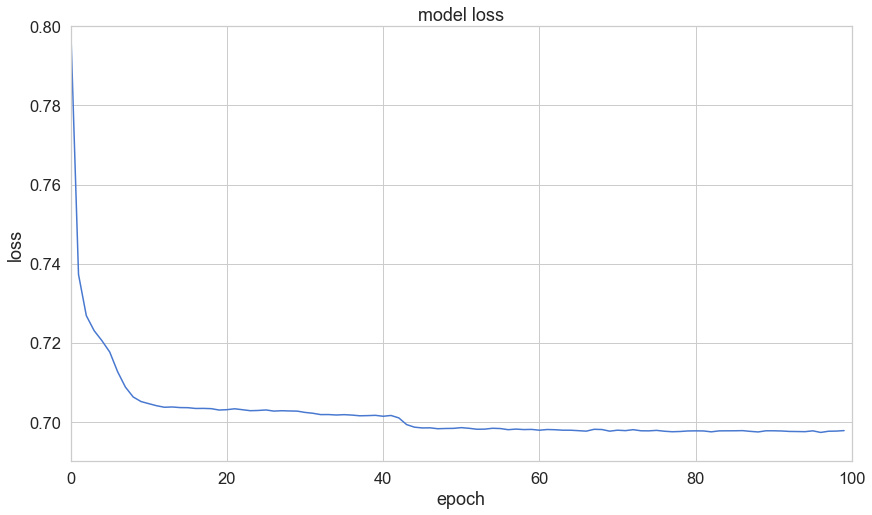

In [82]:
#history['train_loss']
#plt.plot(range(num_epochs),history['train_loss'],'ro',linewidth=2.0)
plt.plot(history['train_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.axis([0,100,0.69,0.80])
#plt.legend(['train', 'test'], loc='upper right');
plt.show()

### Evaluation

In [83]:
pred_losses = {'pred_loss' : []}
model.eval()
with torch.no_grad():
   # test_loss = 0
    for data in test_loader:
        inputs = data
        # print(inputs)
        outputs = model(inputs)
        loss = criterion(outputs, inputs).data.item()
        #print(loss)
        pred_losses['pred_loss'].append(loss)
        #pred_losses = model([y_test.size, y_test])
reconstructionErrorDF = pd.DataFrame(pred_losses)
reconstructionErrorDF['Class'] = y_test

In [85]:
reconstructionErrorDF

,pred_loss,Class
0,81.224012,1
1,0.802764,0
2,0.218104,0
3,0.407919,0
4,0.165165,0
...,...,...
56957,0.772996,0
56958,0.191565,0
56959,0.518516,0
56960,0.153490,0


In [84]:
reconstructionErrorDF.describe()

,pred_loss,Class
count,56962.000000,56962.000000
mean,0.729762,0.001720
std,3.469029,0.041443
min,0.043842,0.000000
25%,0.236348,0.000000
50%,0.377951,0.000000
75%,0.604818,0.000000
max,254.944682,1.000000


### Reconstruction Errors without Fraud

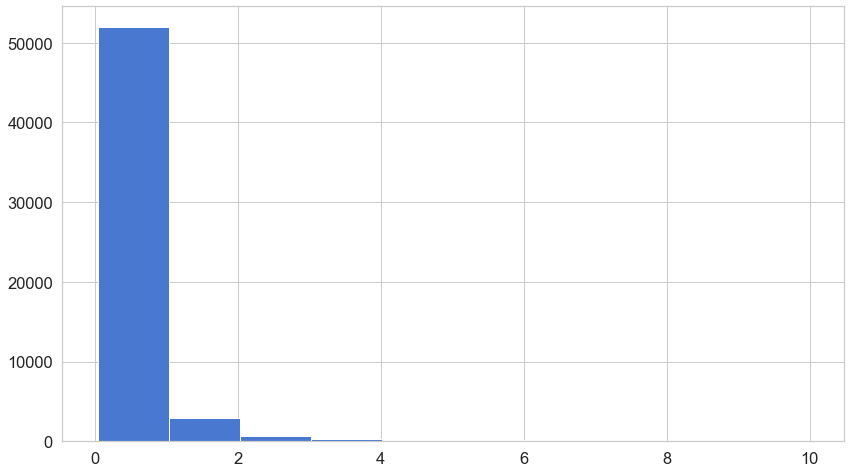

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111)
normal_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 0) & (reconstructionErrorDF['pred_loss'] < 10)]
_ = ax.hist(normal_error_df.pred_loss.values, bins=10)

In [95]:
normal_error_df

,pred_loss,Class
1,0.802764,0
2,0.218104,0
3,0.407919,0
4,0.165165,0
5,0.933250,0
...,...,...
56957,0.772996,0
56958,0.191565,0
56959,0.518516,0
56960,0.153490,0


### Reconstruction Errors with Fraud

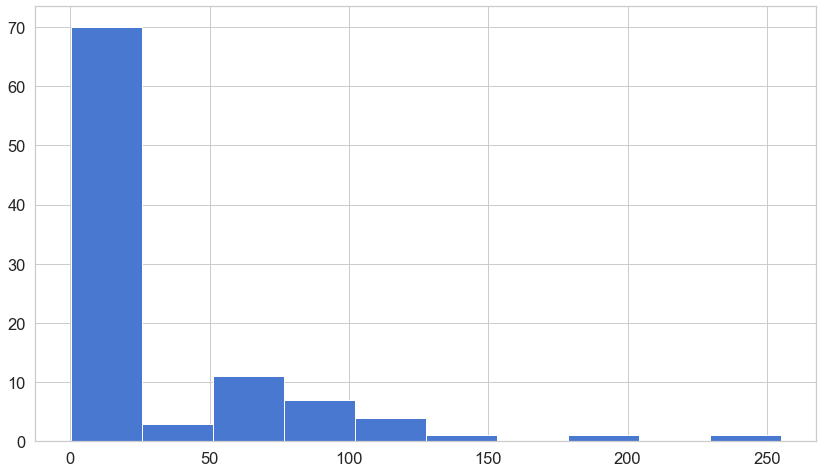

In [87]:
fig = plt.figure()
ax = fig.add_subplot(111)
fraud_error_df = reconstructionErrorDF[(reconstructionErrorDF['Class']== 1) ]
_ = ax.hist(fraud_error_df.pred_loss.values, bins=10)

### ROC Curves
The receiver operating characteristics curve, or ROC curve for short are used very commonly for analysing the binary classifiers. It considers all possible thresholds for a given classifier and shows false positive rate (FPR) against true positive rates (TPR)

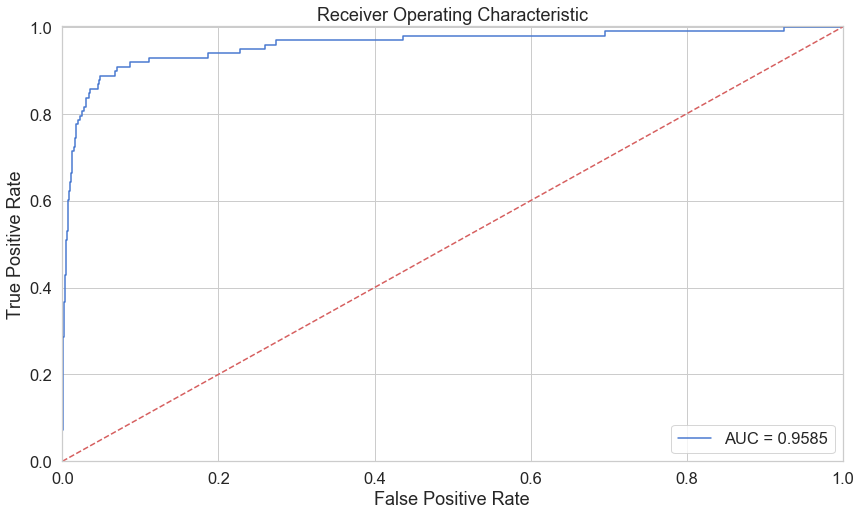

In [88]:
fpr, tpr, thresholds = roc_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, label='AUC = %0.4f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.001, 1])
plt.ylim([0, 1.001])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show();

### Precision vs Recall
Setting a threshold that is used to make a classification decision in a model is a way to adjust the trade-off of precision and recall for a given classifier.

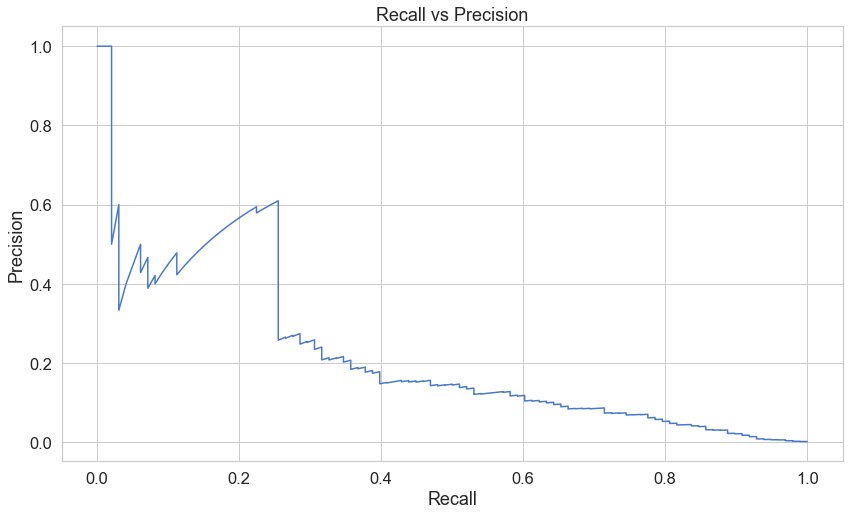

In [89]:
precision, recall, th = precision_recall_curve(reconstructionErrorDF.Class, reconstructionErrorDF.pred_loss)
plt.plot(recall, precision, 'b', label='Precision-Recall curve')
plt.title('Recall vs Precision')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

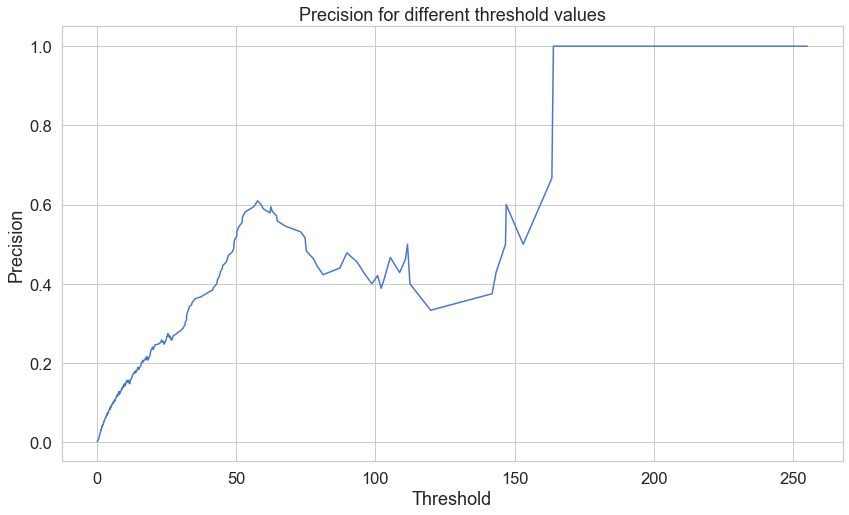

In [90]:
plt.plot(th, precision[1:], 'b', label='Threshold-Precision curve')
plt.title('Precision for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision')
plt.show()

You can see that as the reconstruction error increases our precision rises as well. Let's have a look at the recall:

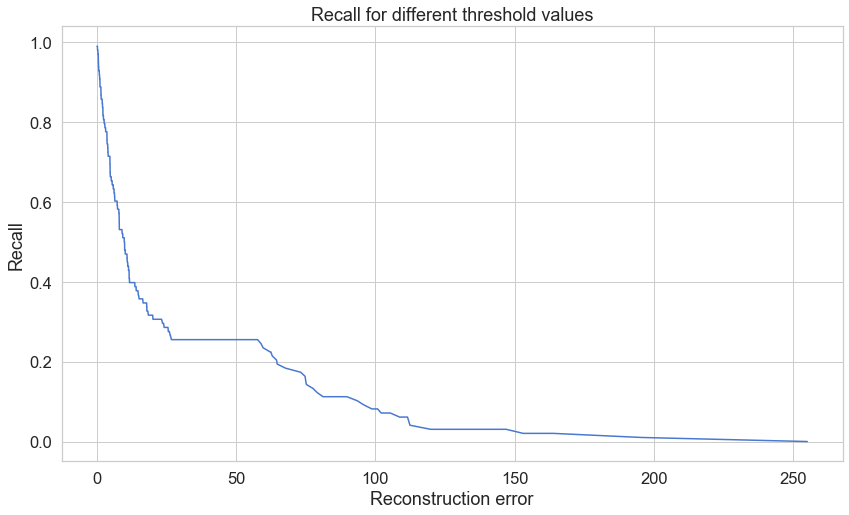

In [91]:
plt.plot(th, recall[1:], 'b', label='Threshold-Recall curve')
plt.title('Recall for different threshold values')
plt.xlabel('Reconstruction error')
plt.ylabel('Recall')
plt.show()

Here, we have the exact opposite situation. As the reconstruction error increases the recall decreases.

### Using the Model to make prediction
In order to predict whether or not a new/unseen transaction is normal or fraudulent, we'll calculate the reconstruction error from the transaction data itself. If the error is larger than a predefined threshold, we'll mark it as a fraud (since our model should have a low error on normal transactions). Let's pick that value:

In [92]:
threshold = 2.9

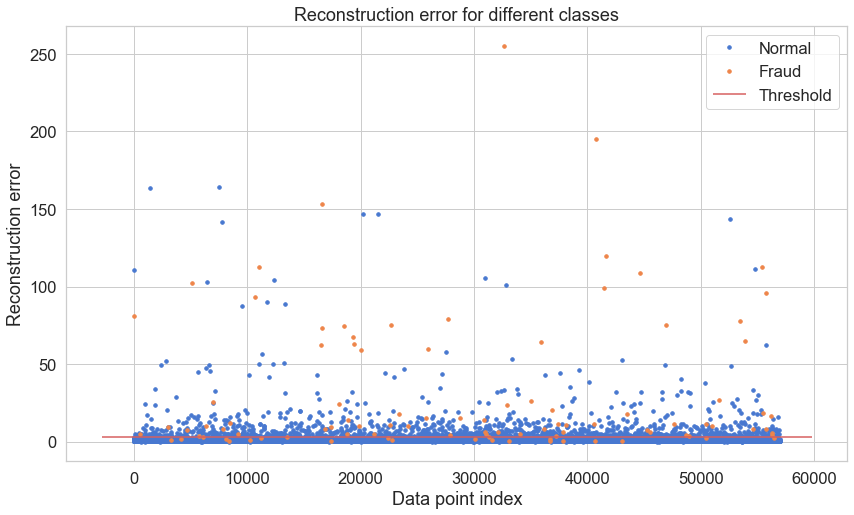

In [93]:
groups = reconstructionErrorDF.groupby('Class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.pred_loss, marker='o', ms=3.5, linestyle='',
            label= "Fraud" if name == 1 else "Normal")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

Let's have a look at the confusion matrix:

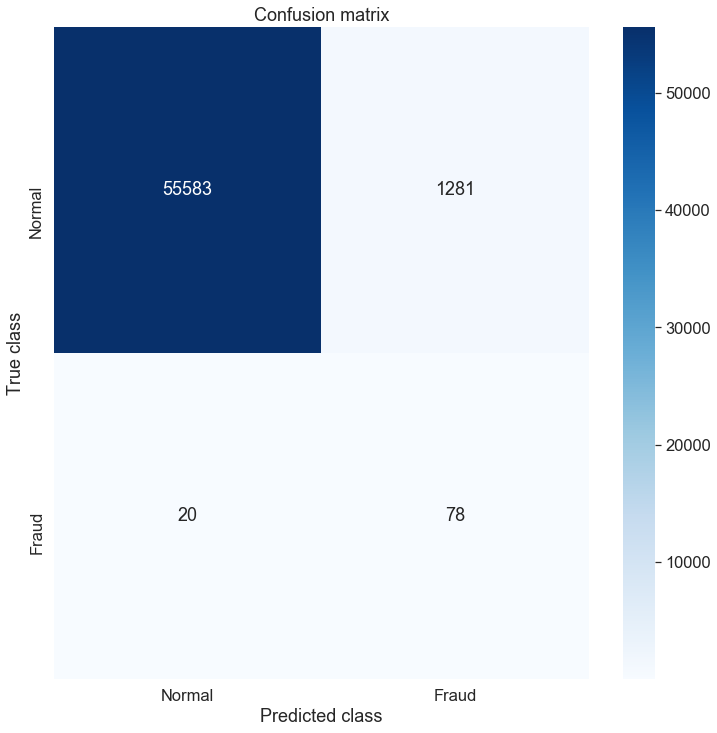

In [94]:
y_pred = [1 if e > threshold else 0 for e in reconstructionErrorDF.pred_loss.values]
conf_matrix = confusion_matrix(reconstructionErrorDF.Class, y_pred)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", 
            cmap=plt.cm.get_cmap('Blues'));
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

Our model seems to catch a lot of the fraudulent cases. But the number of normal transactions classified as frauds is really high. One can tweak the threshold here and there to come up with better results.

### Conclusion
We've created a very simple Deep Autoencoder in PyTorch that can reconstruct what non fraudulent transactions looks like. It has learnt to recognise the non fraudulent transactions by learning some patterns present in the those transactions, what those patterns are that is hard to tell - a mystery of any deep learning neural network.


## KNN

In [105]:
# main libraries
import pandas as pd
import numpy as np
import time

# visual libraries
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
plt.style.use('ggplot')

# sklearn libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef,classification_report,roc_curve
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

C:\Users\USER\anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [101]:
# Lets shuffle the data before creating the subsamples
df = df.sample(frac=1)

frauds = df[df['Class'] == 1]
non_frauds = df[df['Class'] == 0][:492] #ONLY TAKE 492 non-fraud data since the data is imbalanced

new_df = pd.concat([non_frauds, frauds])
# Shuffle dataframe rows
new_df = new_df.sample(frac=1, random_state=42)

new_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
191544,129308.0,0.054682,1.856500,-4.075451,4.100098,-0.800931,-0.292502,-2.317431,1.189747,-0.786238,...,0.618248,0.800932,0.130016,0.288946,-0.366658,0.030307,0.431182,0.110698,80.90,1
166913,118377.0,-0.228313,1.909946,-0.209575,3.136088,1.403545,-0.419421,1.224947,0.015727,-1.912496,...,-0.283693,-0.958789,0.060848,-0.259195,-0.579647,-0.451967,-0.055856,0.094883,29.96,0
154684,102572.0,-28.709229,22.057729,-27.855811,11.845013,-18.983813,6.474115,-43.557242,-41.044261,-13.320155,...,-22.797604,8.316275,5.466230,0.023854,-1.527145,-0.145225,-5.682338,-0.439134,0.01,1
19188,30081.0,-5.651096,-6.791187,1.303808,3.200996,3.879801,-2.474931,-1.930667,0.643018,0.064255,...,0.806615,-0.214749,2.056162,-0.149972,0.957133,-0.107478,-0.283232,0.254691,584.64,0
190205,128738.0,-1.007053,1.646733,-1.939530,0.067680,-0.481343,-1.380045,0.022178,0.821850,-0.307510,...,0.429426,0.970747,0.122928,-0.076505,-0.239416,-0.173864,-0.656391,-0.221001,49.00,0


Text(0, 0.5, 'Frequency')

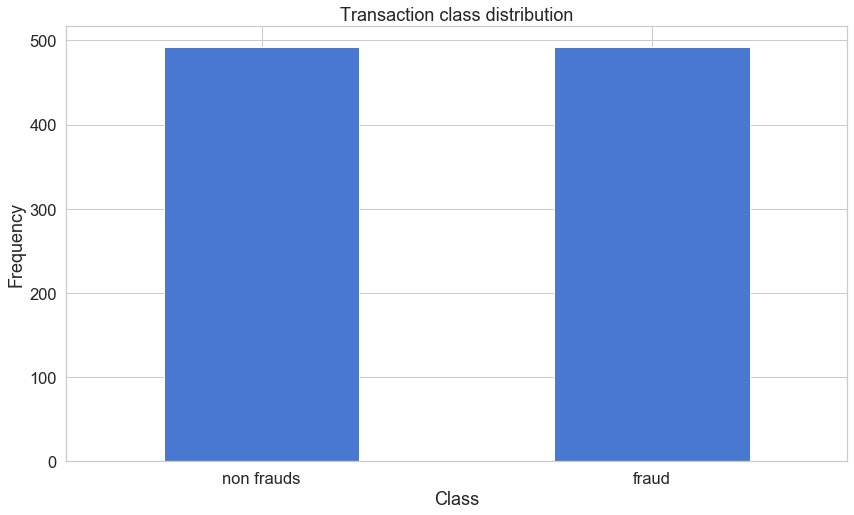

In [102]:
# Let's plot the Transaction class against the Frequency
labels = ['non frauds','fraud']
classes = pd.value_counts(new_df['Class'], sort = True)
classes.plot(kind = 'bar', rot=0)
plt.title("Transaction class distribution")
plt.xticks(range(2), labels)
plt.xlabel("Class")
plt.ylabel("Frequency")

In [103]:
# prepare the data
features = new_df.drop(['Class'], axis = 1)
labels = pd.DataFrame(new_df['Class'])

feature_array = features.values
label_array = labels.values

In [106]:
# splitting the faeture array and label array keeping 80% for the trainnig sets
X_train,X_test,y_train,y_test = train_test_split(feature_array,label_array,test_size=0.20)

# normalize: Scale input vectors individually to unit norm (vector length).
X_train = normalize(X_train)
X_test=normalize(X_test)

In [107]:
neighbours = np.arange(1,25)
train_accuracy =np.empty(len(neighbours))
test_accuracy = np.empty(len(neighbours))

for i,k in enumerate(neighbours):
    #Setup a knn classifier with k neighbors
    knn=KNeighborsClassifier(n_neighbors=k,algorithm="kd_tree",n_jobs=-1)
    
    #Fit the model
    knn.fit(X_train,y_train.ravel())
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train.ravel())
    
    #Compute accuracy on the test set
    test_accuracy[i] = knn.score(X_test, y_test.ravel()) 

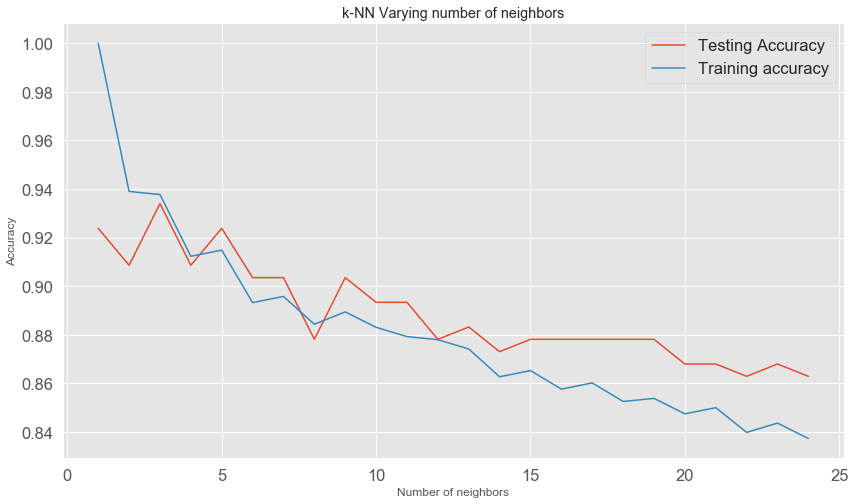

In [108]:
#Generate plot
plt.title('k-NN Varying number of neighbors')
plt.plot(neighbours, test_accuracy, label='Testing Accuracy')
plt.plot(neighbours, train_accuracy, label='Training accuracy')
plt.legend()
plt.xlabel('Number of neighbors')
plt.ylabel('Accuracy')
plt.show()

In [109]:
idx = np.where(test_accuracy == max(test_accuracy))
x = neighbours[idx]

In [110]:
#k_nearest_neighbours_classification
knn=KNeighborsClassifier(n_neighbors=x[0],algorithm="kd_tree",n_jobs=-1)
knn.fit(X_train,y_train.ravel())

KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=-1, n_neighbors=3, p=2,
                     weights='uniform')

In [111]:
#predicting labels for testing set
knn_predicted_test_labels=knn.predict(X_test)

In [113]:
#scoring knn
knn_accuracy_score  = accuracy_score(y_test,knn_predicted_test_labels)
knn_precison_score  = precision_score(y_test,knn_predicted_test_labels)
knn_recall_score    = recall_score(y_test,knn_predicted_test_labels)
knn_f1_score        = f1_score(y_test,knn_predicted_test_labels)
knn_MCC             = matthews_corrcoef(y_test,knn_predicted_test_labels)

In [114]:
#printing
print("")
print("K-Nearest Neighbours")
print("Scores")
print("Accuracy -->",knn_accuracy_score)
print("Precison -->",knn_precison_score)
print("Recall -->",knn_recall_score)
print("F1 -->",knn_f1_score)
print("MCC -->",knn_MCC)
print(classification_report(y_test,knn_predicted_test_labels))


K-Nearest Neighbours
Scores
Accuracy --> 0.934010152284264
Precison --> 0.9493670886075949
Recall --> 0.8928571428571429
F1 --> 0.920245398773006
MCC --> 0.8652420834742182
              precision    recall  f1-score   support

           0       0.92      0.96      0.94       113
           1       0.95      0.89      0.92        84

    accuracy                           0.93       197
   macro avg       0.94      0.93      0.93       197
weighted avg       0.93      0.93      0.93       197



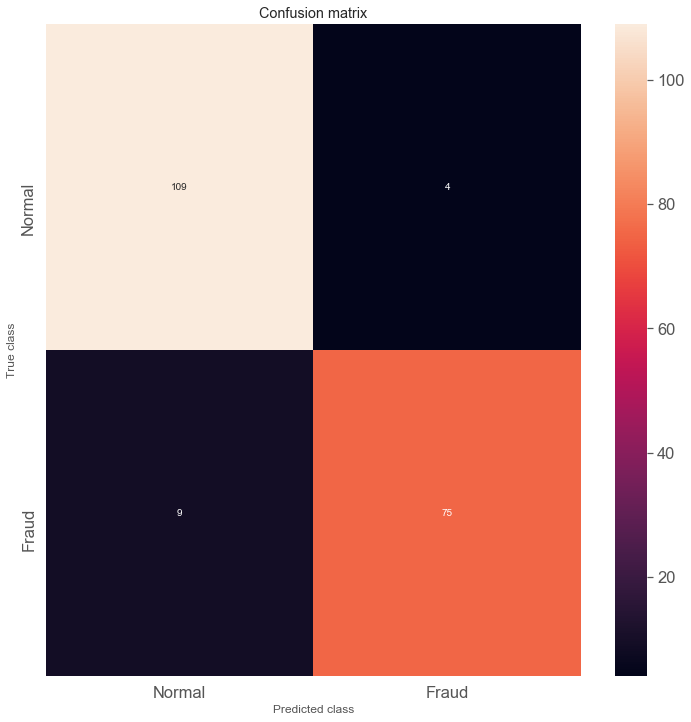

In [115]:
import seaborn as sns
LABELS = ['Normal', 'Fraud']
conf_matrix = confusion_matrix(y_test, knn_predicted_test_labels)
plt.figure(figsize=(12, 12))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()